In [21]:
from PIL import Image
import torch
import torchvision
import random
import torch.nn.functional as F
import numpy as np

from torchsummary import summary
from torch import nn

from config import *
from utils import *
from models.SFMCNN import SFMCNN
from models.RGB_SFMCNN import RGB_SFMCNN
from models.RGB_SFMCNN_V2 import RGB_SFMCNN_V2
from dataloader import get_dataloader

import matplotlib


matplotlib.use('Agg')

'''
	對某個資料集產生RM，RM-CI
'''

with torch.no_grad():
    # Load Dataset
    train_dataloader, test_dataloader = get_dataloader(dataset=config['dataset'], root=config['root'] + '/data/',
                                                       batch_size=config['batch_size'],
                                                       input_size=config['input_shape'])
    images, labels = torch.tensor([]), torch.tensor([])
    for batch in test_dataloader:
        imgs, lbls = batch
        images = torch.cat((images, imgs))
        labels = torch.cat((labels, lbls))
    print(images.shape, labels.shape)

    # Load Model
    models = {'SFMCNN': SFMCNN, 'RGB_SFMCNN': RGB_SFMCNN, 'RGB_SFMCNN_V2': RGB_SFMCNN_V2}
    checkpoint_filename = 'RGB_SFMCNN_V2_best'
    checkpoint = torch.load(f'./pth/{config["dataset"]}_pth/{checkpoint_filename}.pth', weights_only=True)
    model = models[arch['name']](**dict(config['model']['args']))
    model.load_state_dict(checkpoint['model_weights'])
    model.cpu()
    model.eval()
    summary(model, input_size=(config['model']['args']['in_channels'], *config['input_shape']), device='cpu')
    print(model)

    # Test Model
    batch_num = 1000
    pred = model(images[:batch_num])
    y = labels[:batch_num]
    correct = (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    print("Test Accuracy: " + str(correct / len(pred)))
    # input()


torch.Size([900, 3, 28, 28]) torch.Size([900, 9])


RuntimeError: Error(s) in loading state_dict for RGB_SFMCNN_V2:
	Missing key(s) in state_dict: "RGB_conv2d.1.w", "GRAY_conv2d.1.w", "RGB_convs.0.1.w", "RGB_convs.2.1.w", "RGB_convs.3.1.w", "Gray_convs.0.1.w", "Gray_convs.2.1.w", "Gray_convs.3.1.w". 

In [3]:
layers = get_layers(model)

In [9]:
# 新增的迴圈來讀取指定資料夾中的圖片
input_folder = f'./detect/{config["dataset"]}_{checkpoint_filename}/test_images/'  # 指定資料夾路徑
image_files = os.listdir(input_folder)

images = []
for image_file in image_files:
    if image_file.endswith(('.png', '.jpg', '.jpeg')):  # 檢查檔案類型
        # 讀取圖片
        image_path = os.path.join(input_folder, image_file)
        test_image = Image.open(image_path).convert('RGB')  # 轉換為 RGB 格式
        test_image = torchvision.transforms.ToTensor()(test_image)  # 轉換為 Tensor

        images.append(test_image)

image = images[0]

In [13]:
# 繪製 image
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))  # 調整維度以適應 imshow
plt.axis('off')  # 不顯示坐標軸
plt.savefig('output_image.png', bbox_inches='tight', pad_inches=0)  # 保存圖片
plt.close()  # 關閉圖形以釋放資源

In [7]:
layer_num = 'RGB_convs_0_Conv'

RM = layers[layer_num](image.unsqueeze(0))[0]

input torch.Size([1, 3, 28, 28])
output_width 6
output_height 6
self.kernel_size (5, 5), self.stride 4, self.padding : 0
windowtorch.Size([1, 36, 75])
window after torch.Size([1, 36, 3, 25])
windows_RGBcolor torch.Size([1, 36, 3])
windows_RGBcolortorch.Size([1, 36, 1, 3])
weights_RGBcolortorch.Size([30, 3])
rmean torch.Size([1, 36, 30])
R_1 torch.Size([1, 36, 1])
R_2 torch.Size([30])
distance torch.Size([1, 36, 30])


In [16]:
RM[0]

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

In [18]:
RM.permute(1, 2, 0).shape

torch.Size([6, 6, 30])

In [20]:
RM.permute(1, 2, 0)[0][0]

tensor([1.0000e+00, 7.1590e-01, 4.8301e-01, 2.6852e-01, 3.4532e-01, 1.4462e-01,
        1.8236e-01, 6.2126e-01, 6.5011e-01, 4.2237e-01, 4.1548e-01, 3.1999e-01,
        6.7625e-01, 7.8550e-01, 7.0104e-01, 4.2136e-01, 2.8799e-01, 7.9499e-01,
        6.8701e-01, 7.1448e-01, 6.5988e-01, 6.7563e-01, 5.2605e-01, 3.4902e-01,
        2.3459e-01, 6.5762e-01, 5.9805e-01, 4.6262e-01, 3.9209e-01, 1.3072e-07])

In [8]:
import torch

# 定義 batched LAB 距離計算函數
def batched_LAB_distance(windows_RGBcolor, weights_RGBcolor):
    print(f"windows_RGBcolor{windows_RGBcolor.shape}")
    print(f"weights_RGBcolor{weights_RGBcolor.shape}")
    # RGB 顏色數據從 [0, 1] 映射到 [0, 255]
    R_1, G_1, B_1 = windows_RGBcolor[:, :, :, 0] * 255, windows_RGBcolor[:, :, :, 1] * 255, windows_RGBcolor[:, :, :, 2] * 255
    R_2, G_2, B_2 = weights_RGBcolor[:, 0] * 255, weights_RGBcolor[:, 1] * 255, weights_RGBcolor[:, 2] * 255

    # 計算 rmean 作為矩陣形式
    rmean = (R_1 + R_2) / 2
    print(f"rmean {rmean.shape}")
    print(f"R_1 {R_1.shape}")
    print(f"R_2 {R_2.shape}")

    # 計算 RGB 分量的差異
    R = R_1 - R_2
    G = G_1 - G_2
    B = B_1 - B_2

    print(f"R {R.shape}")

    # 計算加權的歐幾里得距離
    distance = torch.sqrt(
        (2 + rmean / 256) * (R ** 2) +
        4 * (G ** 2) +
        (2 + (255 - rmean) / 256) * (B ** 2) +
        1e-8
    )

    print(f"distance {distance.shape}")

    return distance

# 測試案例 1: 4 個色塊（3 黑色，1 紅色）
windows_RGBcolor_1 = torch.tensor([[[[0, 0, 0]], [[1, 1, 0]], [[1, 1, 0.5]], [[1, 0, 0]]],[[[0, 0, 0]], [[1, 1, 0]], [[1, 1, 0.5]], [[1, 0, 0]]]], dtype=torch.float32)  # (2, 4, 1, 3)
weights_RGBcolor = torch.rand((10, 3), dtype=torch.float32)  # 隨機生成 10 種顏色

# 測試案例 2: 4 個色塊（3 黑色，1 藍色）
windows_RGBcolor_2 = torch.tensor([[[[0, 0, 0]], [[0, 0, 0]], [[0, 0, 0]], [[0, 0, 1]]],[[[0, 0, 0]], [[1, 1, 0]], [[1, 1, 0.5]], [[1, 0, 0]]]], dtype=torch.float32)  # (2, 4, 1, 3)

# 執行測試
output_1 = batched_LAB_distance(windows_RGBcolor_1, weights_RGBcolor)
output_2 = batched_LAB_distance(windows_RGBcolor_2, weights_RGBcolor)

# 印出測試結果
print("測試案例 1 的輸出:")
print(output_1)

print("\n測試案例 2 的輸出:")
print(output_2)

windows_RGBcolortorch.Size([2, 4, 1, 3])
weights_RGBcolortorch.Size([10, 3])
rmean torch.Size([2, 4, 10])
R_1 torch.Size([2, 4, 1])
R_2 torch.Size([10])
R torch.Size([2, 4, 10])
distance torch.Size([2, 4, 10])
windows_RGBcolortorch.Size([2, 4, 1, 3])
weights_RGBcolortorch.Size([10, 3])
rmean torch.Size([2, 4, 10])
R_1 torch.Size([2, 4, 1])
R_2 torch.Size([10])
R torch.Size([2, 4, 10])
distance torch.Size([2, 4, 10])
測試案例 1 的輸出:
tensor([[[363.1786, 136.1939, 472.0239, 202.7654, 430.0359, 531.0891, 385.7161,
          443.7305, 403.8653, 195.4285],
         [288.3929, 575.1699, 285.4569, 545.4024, 414.7142, 211.2638, 281.8374,
          297.7462, 447.1385, 489.5802],
         [333.1699, 583.4155, 222.5891, 528.2444, 332.7450, 183.2632, 312.1161,
          253.8985, 395.9901, 493.3661],
         [326.4185, 304.9381, 417.9102, 379.4245, 426.4863, 496.6077, 290.8953,
          431.8494, 263.3833, 352.7389]],

        [[363.1786, 136.1939, 472.0239, 202.7654, 430.0359, 531.0891, 385.7161,
  

In [2]:
from dataloader import get_dataloader
from config import config, arch

from torchsummary import summary
from torch import nn


# config['dataset']
# 
# data_name = "HeartCalcification_Gray"
data_name = config['dataset']
train_dataloader, test_dataloader = get_dataloader(dataset=config['dataset'], root=config['root'] + '/data/', batch_size=config['batch_size'], input_size=config['input_shape'])

In [23]:
import torch
import matplotlib.pyplot as plt

import torch
import numpy as np
from collections import Counter


images, labels = torch.tensor([]), torch.tensor([])
for batch in test_dataloader:
    imgs, lbls = batch
    images = torch.cat((images, imgs))
    labels = torch.cat((labels, lbls))

# 調整形狀為 (900*28*28, 3)
images_flat = images.permute(0, 2, 3, 1).reshape(-1, 3).numpy()

# 使用 Counter 統計每種 RGB 像素點的出現次數
pixel_counts = Counter(map(tuple, images_flat))

# 輸出結果
for pixel, count in pixel_counts.items():
    print(f"{pixel} : {count}")

(0.0, 0.0, 0.0) : 523815
(1.0, 0.0, 0.0) : 60595
(0.0, 1.0, 0.0) : 60595
(0.0, 0.0, 1.0) : 60595


In [2]:
 from PIL import Image
import torch
import torchvision
import random
import torch.nn.functional as F
import numpy as np

from torchsummary import summary
from torch import nn

from config import *
from utils import *
from models.SFMCNN import SFMCNN
from models.RGB_SFMCNN import RGB_SFMCNN
from models.RGB_SFMCNN_V2 import RGB_SFMCNN_V2
from dataloader import get_dataloader

import matplotlib
 
train_dataloader, test_dataloader = get_dataloader(dataset=config['dataset'], root=config['root'] + '/data/',
                                                       batch_size=config['batch_size'],
                                                       input_size=config['input_shape'])

Code/runs/train/exp


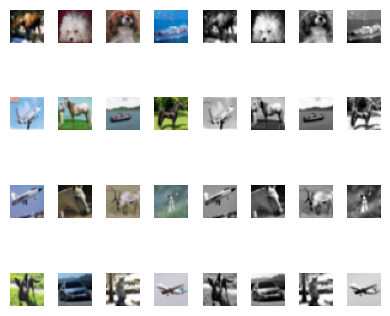

In [4]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = torch.tensor([]), torch.tensor([])
for batch in train_dataloader:
    imgs, lbls = batch
    images = torch.cat((images, imgs))
    labels = torch.cat((labels, lbls))


# 設定顯示的圖片數量
num_images = min(16, images.size(0))  # 最多顯示100張圖片
grid_size = 4  # 10x10的網格

# 創建一個10x10的子圖
fig, axes = plt.subplots(grid_size, grid_size * 2, figsize=(grid_size, grid_size))  # 兩列

for i in range(grid_size):
    for j in range(grid_size):
        index = i * grid_size + j
        if index < num_images:
            # 顯示彩色圖片
            axes[i, j].imshow(images[index].permute(1, 2, 0))  # 調整維度以適應imshow
            axes[i, j].axis('off')  # 不顯示坐標軸
            
            # 顯示黑白圖片
            gray_image = images[index].mean(dim=0)  # 將彩色圖片轉換為黑白
            axes[i, j + grid_size].imshow(gray_image, cmap='gray')  # 使用灰度顏色映射
            axes[i, j + grid_size].axis('off')  # 不顯示坐標軸

plt.tight_layout()
plt.show()

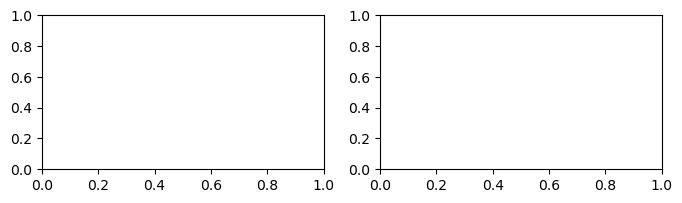

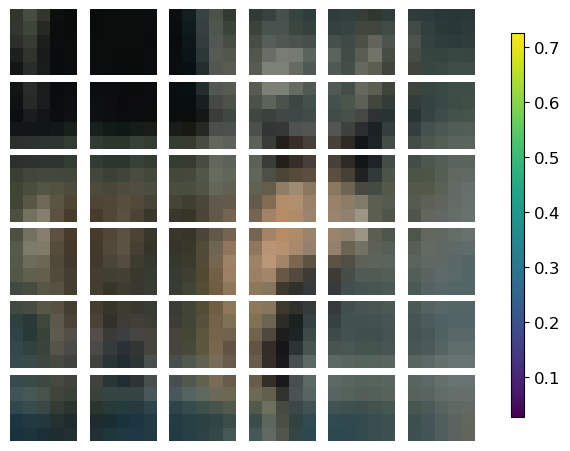

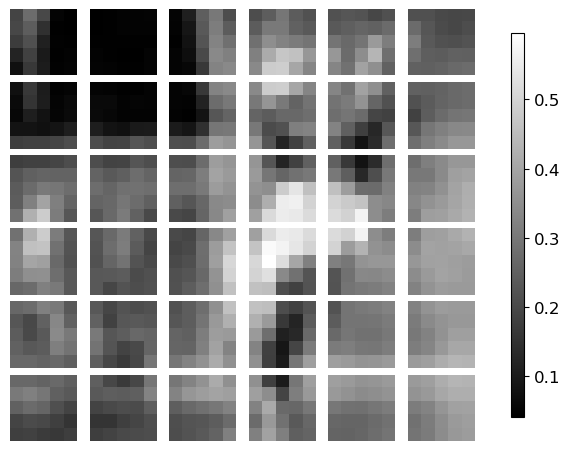

In [23]:
num_images = 1  # 指定要顯示的圖片對數量
image_indices = range(num_images)  # 生成圖片索引

# 創建一個子圖來顯示彩色和灰階圖片的小格
fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))  # num_images行2列的子圖

save_path = "D:\Paper\RGB_SFM\images"

figs = {}
for i, image_index in enumerate(image_indices):
    image = images[image_index]  # 獲取指定的圖片

    # 繪製彩色圖片
    segments = split(image.unsqueeze(0), kernel_size=arch['args']['Conv2d_kernel'][0],
                     stride=(arch['args']['strides'][0], arch['args']['strides'][0]))[0]
    figs['c'] = plot_map(segments.permute(1, 2, 3, 4, 0), path=save_path + f'\origin_split_{i}.png')

    # 新增：將彩色圖片轉換為灰階
    gray_image = image.mean(dim=0, keepdim=True)  # 將彩色圖片轉換為灰階

    # 繪製灰階圖片
    gray_segments = split(gray_image.unsqueeze(0), kernel_size=arch['args']['Conv2d_kernel'][0],
                          stride=(arch['args']['strides'][0], arch['args']['strides'][0]))[0]
    figs['g'] = plot_map(gray_segments.permute(1, 2, 3, 4, 0), path=save_path + f'\gray_split_{i}.png', cmap='gray')
    
    plot_combine_images(figs, save_path + f'\combine_{i}')

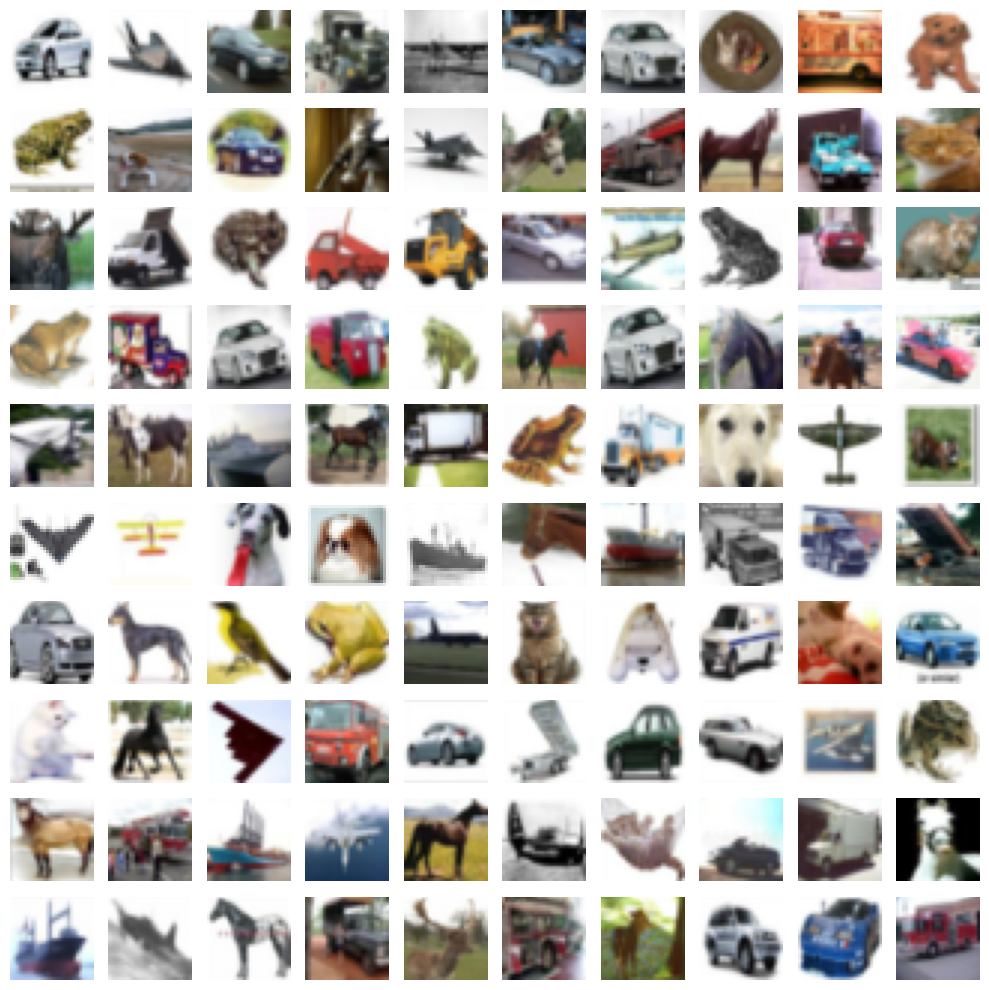

In [5]:
import torch
import matplotlib.pyplot as plt

images, labels = torch.tensor([]), torch.tensor([])
for batch in test_dataloader:
    imgs, lbls = batch
    images = torch.cat((images, imgs))
    labels = torch.cat((labels, lbls))

# 找到所有包含 (255, 255, 255) 像素的圖片
white_pixel_images = []
for img in images:
    if (img == 1).all(dim=0).any():  # 假設圖片的像素值範圍是 [0, 1]
        white_pixel_images.append(img)

# 設定顯示的圖片數量
num_images = min(100, len(white_pixel_images))  # 最多顯示100張圖片
grid_size = 10  # 10x10的網格

# 創建一個10x10的子圖
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i in range(grid_size):
    for j in range(grid_size):
        index = i * grid_size + j
        if index < num_images:
            axes[i, j].imshow(white_pixel_images[index].permute(1, 2, 0))  # 調整維度以適應imshow
        axes[i, j].axis('off')  # 不顯示坐標軸

plt.tight_layout()
plt.show()

In [1]:

from torchsummary import summary
from torch import nn
import torch

from loss.loss_function import get_loss_function
from models.SFMCNN import SFMCNN
from models.RGB_SFMCNN import RGB_SFMCNN
from models.RGB_SFMCNN_V2 import RGB_SFMCNN_V2
from dataloader import get_dataloader
from config import *


from monitor.monitor_method import get_all_layers_stats
from monitor.plot_monitor import plot_all_layers_graph

with torch.no_grad():
    # Load Dataset
    train_dataloader, test_dataloader = get_dataloader(dataset=config['dataset'], root=config['root'] + '/data/',
                                                       batch_size=config['batch_size'],
                                                       input_size=config['input_shape'])
    images, labels = torch.tensor([]), torch.tensor([])
    for batch in test_dataloader:
        imgs, lbls = batch
        images = torch.cat((images, imgs))
        labels = torch.cat((labels, lbls))
    print(images.shape, labels.shape)

    # Load Model
    models = {'SFMCNN': SFMCNN, 'RGB_SFMCNN': RGB_SFMCNN, 'RGB_SFMCNN_V2': RGB_SFMCNN_V2}
    checkpoint_filename = 'RGB_SFMCNN_V2_best'
    checkpoint = torch.load(f'./pth/{config["dataset"]}_pth/{checkpoint_filename}.pth', weights_only=True)
    model = models[arch['name']](**dict(config['model']['args']))
    model.load_state_dict(checkpoint['model_weights'])
    model.cpu()
    model.eval()
    summary(model, input_size=(config['model']['args']['in_channels'], *config['input_shape']), device='cpu')
    print(model)

    # Test Model
    batch_num = 1000
    pred = model(images[:batch_num])
    y = labels[:batch_num]
    correct = (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    print("Test Accuracy: " + str(correct / len(pred)))

    loss_fn = get_loss_function(config['loss_fn'])
    loss = loss_fn(pred, y)
    # input()

Code/runs/train/exp
torch.Size([900, 3, 28, 28]) torch.Size([900, 9])


FileNotFoundError: [Errno 2] No such file or directory: './pth/MultiColor_Shapes_Database_pth/RGB_SFMCNN_V2_best.pth'